In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Logistic Regression

### Logistic Regression Code:
https://github.com/jblake05/jblake05.github.io/blob/main/posts/Logistic/logistic.py

## Abstract

This blog post explores the logistic regression model. This first involved the creation of the model, which is documented above. Then, I use the logistic regression model in a variety of experiments, including those with differing momentum and dimensionality values. Specifically, these experiments are a default test (no momentum, 2-dimensions), a test with momentum (keeping other values equal), and a test with significantly more dimensions than data points (p = 100, n = 50). By doing so, we can explore how the logistic regression model can be successfully used and how it reacts to different parameters.

## Data Creation

First, I import my model alongside torch, numpy, and matplotlib.

In [64]:
from logistic import LogisticRegression, GradientDescentOptimizer
import torch
import numpy as np
import matplotlib.pyplot as plt

Then, using the classification_data method provided in the assignment, I generate linearly inseparable data to test the logstic regression model on.

In [65]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

## Visualization Methods

Next, I bring in methods from the perceptron assignment to plot the data and draw lines for decision boundaries. This will be important for the first experiment to show the model's weight vector changing over time. 

In [66]:
# from perceptron lecture

def plot_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

In [67]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

These next two methods, also taken from the perceptron assignment, are adapted to better suit these experiments. The plot_decisions function only shows the first and last five decision boundary changes (instead of all changes like in the perceptron). Both were also changed to take in their necessary vectors in order to reduce the amount of times they're repeated in the code.

In [68]:
# plots the first and last 5 iterations of the decision boundary
def plot_decisions(X, y, weight_vec, loss_vec):
        # set up the figure
        current_ax = 0
        plt.rcParams["figure.figsize"] = (10, 8)
        fig, axarr = plt.subplots(2, 5, sharex = True, sharey = True)

        # iter through weight_vec

        for i in range(5):
                ax = axarr.ravel()[current_ax]
                plot_data(X, y, ax)
                draw_line(weight_vec[i], x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
                draw_line(weight_vec[i+1], x_min = -1, x_max = 2, ax = ax, color = "black")
                ax.set_title(f"loss = {loss_vec[i]:.3f}")
                ax.set(xlim = (-1, 2), ylim = (-1, 2))
                current_ax += 1
        
        for i in range(len(weight_vec) - 6, len(weight_vec) - 1):
                ax = axarr.ravel()[current_ax]
                plot_data(X, y, ax)
                draw_line(weight_vec[i], x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
                draw_line(weight_vec[i+1], x_min = -1, x_max = 2, ax = ax, color = "black")
                ax.set_title(f"loss = {loss_vec[i]:.3f}")
                ax.set(xlim = (-1, 2), ylim = (-1, 2))
                current_ax += 1
        fig.suptitle("LR Decision Boundaries over Time")

In [69]:
def plot_loss(loss_vec):
    plt.plot(loss_vec, color = "slategrey")
    plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
    labs = plt.gca().set(xlabel = "LR Iteration (Updates Only)", ylabel = "loss")
    plt.title("LR Loss Iterations over Time")

## Training Method

This training method takes in the data X, the target values y, the learning rate alpha, and the momentum value beta (alongside an optional num_steps parameter). It then runs the optimizer on the model for num_steps amount of time, updating the model's weight vector each step. Further, there is included code to keep track of the weight and loss changes. The model, its losses, and its weights are returned for later use and visualization.

In [70]:
def train_LR(X, y, alpha, beta, num_steps=100): 
    LR = LogisticRegression() 
    opt = GradientDescentOptimizer(LR)

    # initialize for main loop
    loss = 1
    loss_vec = []
    weight_vec = [torch.rand(X.size()[1])]

    for _ in range(num_steps):
        prev_loss = loss
        loss = LR.loss(X, y)

        opt.step(X, y, alpha, beta)

        if (prev_loss != loss):
            loss_vec.append(loss)
            weight_vec.append(LR.w)
    return LR, (loss_vec, weight_vec)

## Part B: Experiments

For the first experiment, the training method is run with two dimensional data, a learning rate of 0.1, and no momentum. To achieve a low loss value, the training loop is run for 1000 steps. 

In [71]:
LR, (loss_vec, weight_vec) = train_LR(X, y, 0.1, 0.0, num_steps=1000)

Plotting the decision boundaries, we can see a significant increase in accuracy over time with a decision boundary that more cleanly separates the data.

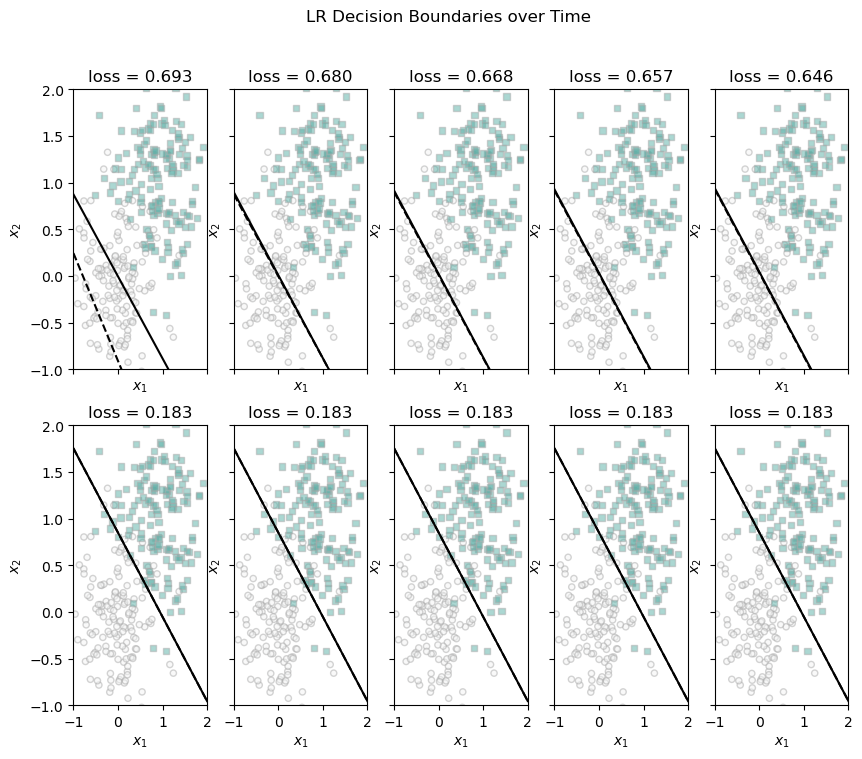

In [72]:
plot_decisions(X, y, weight_vec, loss_vec)

If we plot the loss over time, we similarly see its reduction. This plot makes it clear how the loss decreases in a logistic manner, starting to plateau near the minimum loss value (since the data is linearly inseparable, the minimum is not 0).

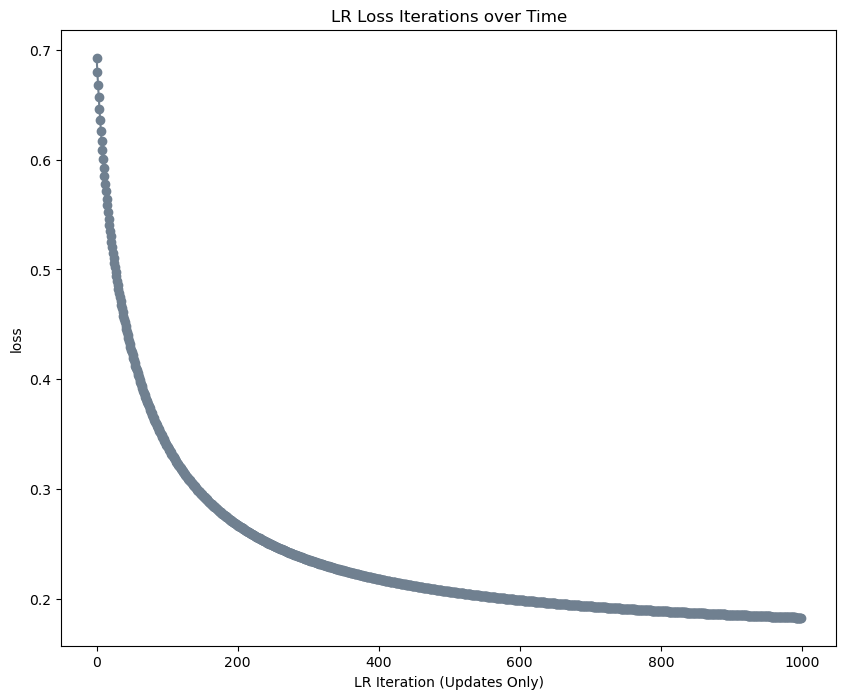

In [73]:
plot_loss(loss_vec)

For the next experiment, I used the same data and learning rate, but changed the momentum from 0 to 0.9. Here, we can see that the loss reaches a low value much faster than the model without momentum (in 100 steps rather than 1000).

In [74]:
LR, (loss_vec, weight_vec) = train_LR(X, y, 0.1, 0.9, num_steps=100)

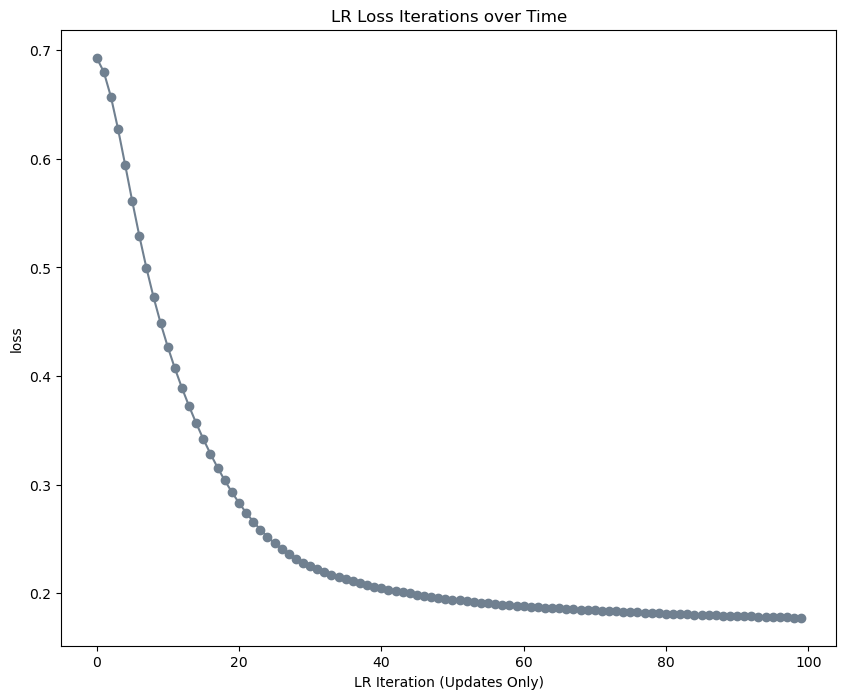

In [75]:
plot_loss(loss_vec)

Finally, this experiment is made to show the effect on high-dimensional data. In particular, this test was for overfitting on data where the number of points is half the amount of dimensions (p == 2n). I first created new data (training and testing), both with 100 dimensions and 50 points of data.

In [76]:
X_train, y_train = classification_data(p_dims = 100, n_points = 50)
X_test, y_test = classification_data(p_dims = 100, n_points = 50)

Since the goal of this experiment was to try to get an accuracy of 100%, I set the number of steps to 25000 to give plenty of time for loss reduction. I kept the learning rate the same, and experimented with the momentum to get low loss values.

In [77]:
LR, (loss_vec, weight_vec) = train_LR(X_train, y_train, 0.1, 0.2, 25000)

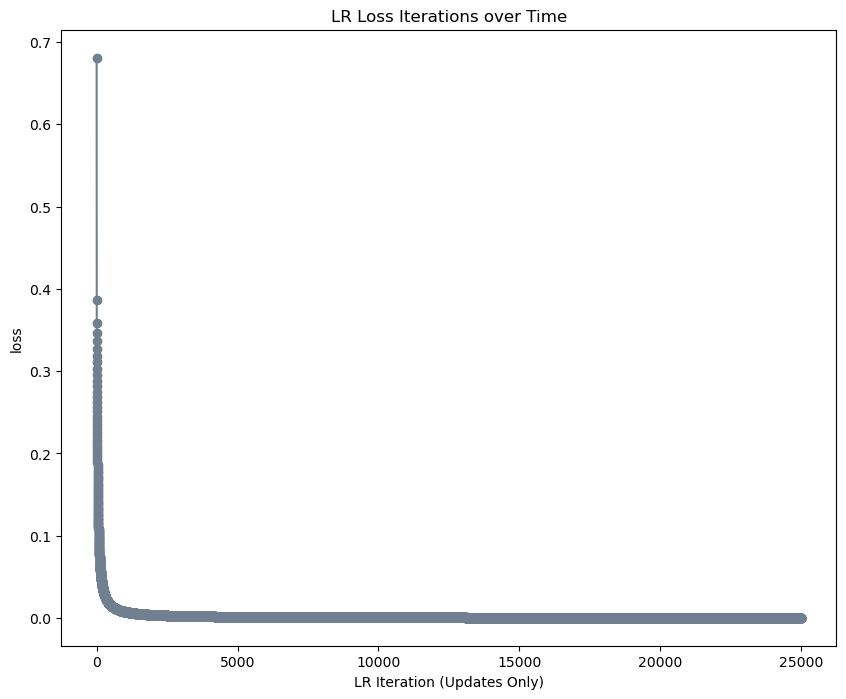

In [78]:
plot_loss(loss_vec)

This training successfully created a model with an extremely high accuracy on the training data. As is seen below, however, I don't think the effects of overfitting are very pronounced here. On the training data, the model achieves an accuracy of 99.97%. On the testing data, it changes to 99.91%. While this is a difference, I think that the performance at the test data is very good considering the relative lack of data and high dimensionality.

In [79]:
loss_vec[len(loss_vec) - 1]

tensor(0.0003)

In [80]:
LR.loss(X_test, y_test)

tensor(0.0009)

## Discussion:

Over the course of this blog post, I built a custom logistic regression model and performed experiments to figure out how it performs under different parameters. In doing so, I found that adding momentum drastically increases the speed of the model. For instance, a model with no momentum achieved a similar loss with 1000 training steps compared to a model using momentum with 100 steps. I also tested the model's behavior on data where the number of dimensions is double the number of data points. While there was an increase in loss between the training data and the testing data, I found that the model had very little overfitting in this instance. In the process of making this model, I learned more about gradient functions and step functions and got to practice the full pipeline of creating, training, and testing models in Python. 